In [1]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 7.8 MB/s eta 0

In [2]:
import gradio as gr

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import datetime, os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
batch_size = 32
img_size = (240, 240)

# create a training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning A1/train',
     shuffle=True, batch_size=batch_size, image_size=img_size,
    validation_split=0.2, subset='training', seed=42
)

# create a validation dataset
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning A1/test',
    shuffle=True, batch_size=batch_size, image_size=img_size,
    validation_split=0.2, subset='validation', seed=42
)

# create a test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning A1/test',
    shuffle=True, batch_size=batch_size, image_size=img_size
)

Found 900 files belonging to 3 classes.
Using 720 files for training.
Found 300 files belonging to 3 classes.
Using 60 files for validation.
Found 300 files belonging to 3 classes.


In [6]:
# Class Names
class_names = train_dataset.class_names
class_names

['Dark', 'Light', 'Medium']

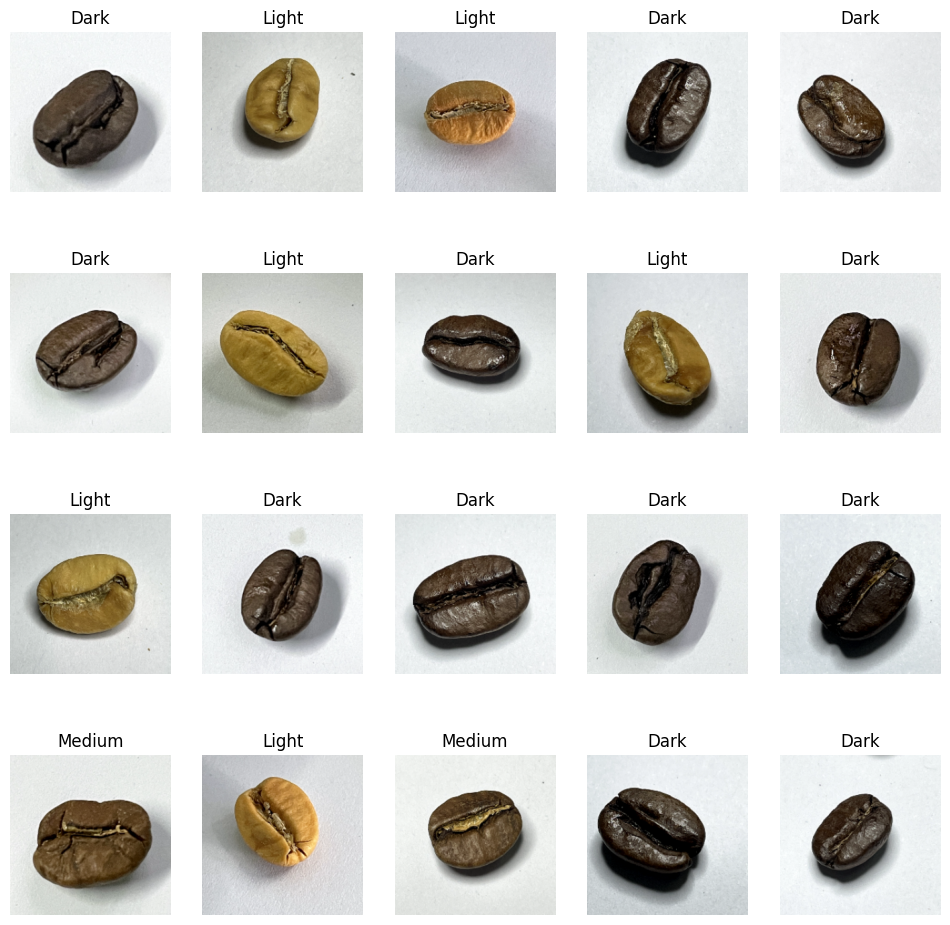

In [7]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(train_dataset.class_names[labels[i]])
        plt.axis('off')

In [8]:
# load a base model
base_model = keras.applications.xception.Xception(input_shape=(224, 224, 3),
                                                  weights='imagenet',
                                                  include_top=False)

83683744/83683744 [==============================] - 0s 0us/step


In [9]:
# create an input layer
input = keras.layers.Input(shape=(240, 240, 3))

# resize and preprocess input images
resized_input = keras.layers.Resizing(224, 224)(input)
preprocessed_input = keras.applications.xception.preprocess_input(resized_input)

# add data augmentation layers to reduce overfitting and make data more diverse
flip = keras.layers.RandomFlip('horizontal')(preprocessed_input)
rotation = keras.layers.RandomRotation(0.2)(flip)
zoom = keras.layers.RandomZoom(0.2)(rotation)

# run preprocessed images through the base model
base_model_output = base_model(zoom)

# add a GlobalAveragePooling layer and a dropout layer to reduce overfitting
avg = keras.layers.GlobalAveragePooling2D()(base_model_output)
dropout = keras.layers.Dropout(0.2)(avg)

# add a fully connected layer with 3 nodes since the dataset has 3 classes
output = keras.layers.Dense(3, activation='softmax')(dropout)

# create a model
model = keras.Model(inputs=input, outputs=output)

In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [11]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])

In [12]:
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
23/23 [==============================] - 173s 7s/step - loss: 1.1620 - accuracy: 0.3528 - val_loss: 1.0893 - val_accuracy: 0.3833
Epoch 2/10
23/23 [==============================] - 167s 7s/step - loss: 1.0289 - accuracy: 0.4847 - val_loss: 0.9691 - val_accuracy: 0.5333
Epoch 3/10
23/23 [==============================] - 158s 7s/step - loss: 0.9309 - accuracy: 0.5847 - val_loss: 0.8614 - val_accuracy: 0.6167
Epoch 4/10
23/23 [==============================] - 168s 7s/step - loss: 0.8253 - accuracy: 0.6806 - val_loss: 0.7765 - val_accuracy: 0.7833
Epoch 5/10
23/23 [==============================] - 168s 7s/step - loss: 0.7692 - accuracy: 0.7194 - val_loss: 0.7067 - val_accuracy: 0.8333
Epoch 6/10
23/23 [==============================] - 168s 7s/step - loss: 0.6989 - accuracy: 0.7750 - val_loss: 0.6492 - val_accuracy: 0.8500
Epoch 7/10
23/23 [==============================] - 160s 7s/step - loss: 0.6570 - accuracy: 0.8000 - val_loss: 0.6022 - val_accuracy: 0.8667
Epoch 8/10
23

In [13]:
model.evaluate(test_dataset)

10/10 [==============================] - 85s 6s/step - loss: 0.4841 - accuracy: 0.8900


[0.4840882420539856, 0.8899999856948853]

Predictions:
 [1 1 2 2 1 0 2 1 1 2 1 0 0 2 2 1 1 2 1 2 2 2 0 2 2 1 0 0 0 1 0 1]
Labels:
 [1 1 1 2 1 0 2 1 1 2 1 0 0 2 2 1 1 2 1 2 2 2 0 2 2 2 0 0 0 1 0 1]


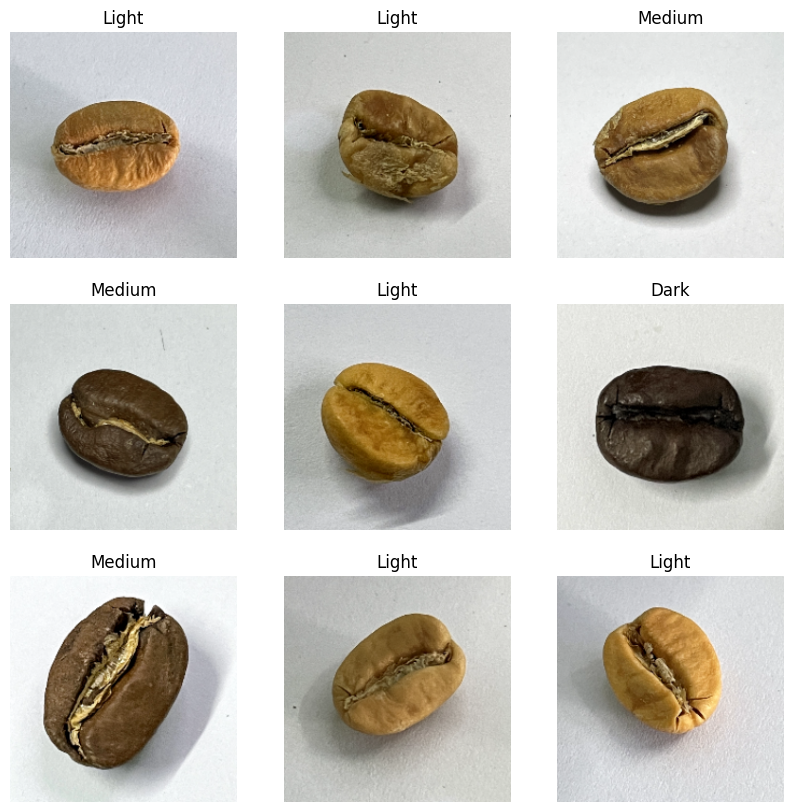

In [14]:
# take a batch of images from the test set and make a prediction
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# apply an argmax since the model
predictions = np.argmax(predictions, axis=-1)

# print predicted and real labels
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

# plot first 9 images with the predicted classes
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [15]:
def predict_image(img):
  img_4d=img.reshape(-1,240,240,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(3)}

In [ ]:
image = gr.inputs.Image(shape=(240,240))
label = gr.outputs.Label(num_top_classes=3)
iface = gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default')
iface.launch(debug=True,share=True)

<ipython-input-16-3eb924d923b6>:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(240,240))
<ipython-input-16-3eb924d923b6>:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(240,240))
<ipython-input-16-3eb924d923b6>:2: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label(num_top_classes=3)
<ipython-input-16-3eb924d923b6>:2: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label(num_top_classes=3)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://491da0e38c637b2d32.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 1s 969ms/step
